In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize as wtoken
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import (Activation, Dropout, Dense, Embedding, Flatten, BatchNormalization, GlobalMaxPooling1D, GRU, Lambda, concatenate, LSTM, Concatenate)
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import os, string, gc, re

from tqdm import tqdm


import tldextract as tld


from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# A quick verification to see if the gpu drivers are ready to serve traning DL
print("Tensorflow Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow Version:  2.0.0
Eager mode:  True
Hub version:  0.7.0
GPU is available
Num GPUs Available:  1


In [3]:
path = '/media/moh/abunayla/Disaster_Tweets/Notebooks/data/'

In [4]:
train = pd.read_csv(path + 'train.csv', usecols = ['text'])

test = pd.read_csv(path + 'test.csv', usecols = ['text'])

samsub = pd.read_csv(path +'sample_submission.csv', index_col = 'id')

Y =  pd.read_csv(path +'train.csv', usecols = ['target'])

In [5]:
train.head()

,text
0,Our Deeds are the Reason of this #earthquake M...
1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...
3,"13,000 people receive #wildfires evacuation or..."
4,Just got sent this photo from Ruby #Alaska as ...


In [6]:
train.shape

(7613, 1)

In [7]:
maxlen =300
training_samples =6000
max_words = 15000

In [8]:
tokenizer = Tokenizer(num_words = max_words, oov_token= 'OOV')

In [9]:
texts = train.text.to_list()
test_text = test.text.to_list()

In [13]:
texts.append

7613

In [14]:
tokenizer.fit_on_texts(test_text + texts)
#tokenizer.fit_on_texts(texts)

In [15]:
sequences = tokenizer.texts_to_sequences(texts)
test_sequences = tokenizer.texts_to_sequences(test_text)

In [16]:
word_index = tokenizer.word_index

In [17]:
print('Found %s unique tokens.' %len( word_index))

Found 29320 unique tokens.


In [18]:
data = pad_sequences(sequences, maxlen=maxlen)

In [19]:
test_data = pad_sequences(test_sequences, maxlen=maxlen)

In [20]:
print('Shape of data tensor:', data.shape)

Shape of data tensor: (7613, 300)


In [21]:
print('Shape of test data tensor:', test_data.shape)

Shape of test data tensor: (3263, 300)


In [22]:
labels = np.asarray(Y.target)

In [23]:
print('Shape of labels tensor:', labels.shape)

Shape of labels tensor: (7613,)


In [24]:
# Splits the data into a training and validations sets.
# also will reshuffle the data.
indices = np.arange(data.shape[0])

In [25]:
np.random.shuffle(indices)

In [26]:
data = data[indices]

In [27]:
labels = labels[indices]

In [28]:
#x_train = data[:training_samples]
x_train = data

In [29]:
x_train.shape

(7613, 300)

In [30]:
#y_train = labels[:training_samples]
y_train = labels

In [ ]:
#x_val = data[training_samples:]

In [ ]:
#x_val.shape

In [ ]:
#y_val = labels[training_samples:]

In [31]:
#assert len(y_val) == len(x_val)

In [32]:
# Glove
glove_dir = path + 'glove.6B.300d.txt'

In [33]:
embeddings_index = {}

In [34]:
f = open(glove_dir)

In [35]:
%%time
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

400000it [00:23, 17361.33it/s]


In [36]:
print('Found word vectors:', len(embeddings_index))

Found word vectors: 400000


In [37]:
embedding_dim = 300

In [38]:
embedding_matrix = np.zeros((max_words, embedding_dim))

In [39]:
for word, i, in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [76]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length= maxlen))
#model.add(Flatten())
model.add(GRU(266, activation = 'tanh', return_sequences = True))
model.add(GRU(128, activation = 'tanh', return_sequences = True))
model.add(GRU(64, activation = 'tanh'))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 300)          4500000   
_________________________________________________________________
gru_15 (GRU)                 (None, 300, 266)          453264    
_________________________________________________________________
gru_16 (GRU)                 (None, 300, 128)          152064    
_________________________________________________________________
gru_17 (GRU)                 (None, 64)                37248     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,142,641
Trainable params: 5,142,641
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [78]:
model.compile(optimizser = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])

In [79]:
history = model.fit(x_train, y_train, epochs =5, batch_size = 128)

Train on 7613 samples
Epoch 1/5
7613/7613 [==============================] - 11s 1ms/sample - loss: 0.5360 - acc: 0.7436
Epoch 2/5
7613/7613 [==============================] - 8s 996us/sample - loss: 0.4379 - acc: 0.8158
Epoch 3/5
7613/7613 [==============================] - 8s 992us/sample - loss: 0.4195 - acc: 0.8190
Epoch 4/5
7613/7613 [==============================] - 8s 990us/sample - loss: 0.3940 - acc: 0.8338
Epoch 5/5
7613/7613 [==============================] - 8s 993us/sample - loss: 0.3713 - acc: 0.8457


In [80]:
model.save_weights(path+'pre_trained_glove_model_full_dataset.h5')

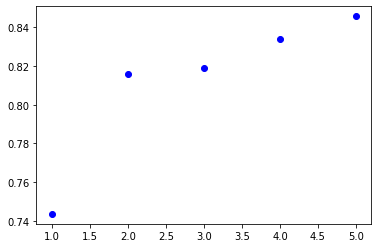

In [81]:
acc = history.history['acc']

#val_acc = history.history['val_acc']

loss = history.history['loss']

#val_loss = history.history['val_loss']

epochs= range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')



In [82]:
#plt.plot(epochs, val_acc, 'b', label = 'Validation')

In [83]:
preds = model.predict(test_data)
preds = np.around(preds)
preds = preds.astype(int)

In [84]:
samsub.target = preds

In [85]:
samsub.head()

,target
id,
0,1
2,1
3,1
9,0
11,1


In [86]:
samsub.to_csv('submission.csv')

# Your Best Entry 

You advanced 584 places on the leaderboard!

Your submission scored 0.81901, which is an improvement of your previous score of 0.80879. Great job!